In [1]:
import gurobipy as gu
import numpy as np
import matplotlib.pyplot as plt
from random import random, seed, randint, lognormvariate
import imageio
import scipy.stats as st

path1 = "C:/Users/juan_/OneDrive - Universidad de los Andes/1. MIIND/Dani/"

In [2]:
''' Simulated historical data generator for quantities, prices and demand of products in each period.
    Returns:
        - M_kt: (dict) subset of suppliers that offer k \in K on t \in T
        - K_it: (dict) subset of products offered by i \in M on t \in T
        - q: (dict) quantity of k \in K offered by supplier i \in M on t \in T
        - p: (dict) price of k \in K offered by supplier i \in M on t \in T
        - dem: (dict) demand of k \in K on t \in T
    Parameters:
        - num_periods: (float) number of historical time periods to simulate, INCLUDING THE REALIZED DEMAND PERIODS
        - lambd: (float) lambda used for demand estimation
        - K: (iter) set of products
        - M: (iter) set of suppliers
        - Periods: (int) number of decision periods of the Rolling Horizon model'''
def gen_prices(num_periods,K,M,Periods):
    
    TW = range(0-num_periods,Periods)
    
    M_kt= {}
    # In each time period, for each product
    for k in K:
        for t in TW:
            # Random number of suppliers that offer k in t
            sup = randint(1,len(M))
            M_kt[k,t] = list(M)
            # Random suppliers are removed from subset, regarding {sup}
            for ss in range(len(M)-sup):
                a = int(randint(0,len(M_kt[k,t])-1))
                del M_kt[k,t][a]
    
    # Products offered by each supplier on each time period, based on M_kt
    K_it = {(i,t):[k for k in K if i in M_kt[k,t]] for i in M for t in TW}
    
    # Random price of available product k, provided by supplier i on t
    p = {(i,k,t):randint(1,500) if i in M_kt[k,t] else 1000 for i in M for k in K for t in TW}
    
    return M_kt, K_it, TW, p


def gen_quantities(K,M,TW,M_kt,q_param=[1,15]):

    # Random quantity of available product k, provided by supplier i on t
    q = {(i,k,t):randint(q_param[0],q_param[1]) if i in M_kt[k,t] else 0 for i in M for k in K for t in TW}

    return q

def gen_demand(K,TW,d_param=[3,1.5]):

    # Random demand of product k on t
    dem = {(k,t):int(lognormvariate(d_param[0],d_param[1])) for k in K for t in TW}

    return dem

''' Rolling horizon model parameters generation function
    Returns:
        - h: (dict) holding cost of k \in K on t \in T
        - O_k: (dict) maximum days that k \in K can be held in inventory
        - c: (dict) transportation cost between nodes i \in V and j \in V
        - I0: (dict) initial inventory level of k \in K, aged o \in O_k
    Parameters:
        - V: (iter) set of nodes in problem network (suppliers + warehouse)
        - T: (iter) set of decision periods in the rolling horizon model
        - K: (iter) set of products
        - M: (iter) set of suppliers
'''
def gen_params(V,T,K,M):
    # Random holding cost of product k on t
    h = {(k,t):randint(1,500) for k in K for t in T}
    # Fixed backorder cost of product k on t
    g = {(k,t):600 for k in K for t in T}
    
    # Maximum days that product k can be held in inventory before rotting
    O_k = {k:randint(1,len(T)) for k in K}
    
    # Suppliers locations in grid
    size_grid = 1000
    coor = {i:(randint(0, size_grid), randint(0, size_grid)) for i in V}
    # Transportation cost between nodes i and j, estimated using euclidean distance
    c = {(i,j):round(np.sqrt((coor[i][0]-coor[j][0])**2 + (coor[i][1]-coor[j][1])**2)) for i in V for j in V if i!=j}
    
    # Initial inventory level of product k, aged o at the beginning of the planning horizon
    I0 = {(k,o):0 for k in K for o in range(1,O_k[k]+1)}
    
    return h, g, O_k, c, I0


In [3]:
# Sample paths Generator

''' Sample value generator function.
    Returns a generated random number using acceptance-rejection method.
    Parameters:
    - hist: (list) historical dataset that is used as an empirical distribution for
            the random number generation'''
def sim(hist):
    Te = len(hist)
    sorted_data = sorted(hist)    
    
    prob, value = [], []
    for t in range(Te):
        prob.append((t+1)/Te)
        value.append(sorted_data[t])
    
    # Generates uniform random value for acceptance-rejection testing
    U = random()
    # Tests if the uniform random falls under the empirical distribution
    test = [i>U for i in prob]    
    # Takes the first accepted value
    sample = value[test.index(True)]
    
    return sample

''' Sample paths generator function.
    Returns:
        - M_kts: (dict) subset of suppliers that offer k \in K on t \in T in sample path s \in Sam
        - K_its: (dict) subset of products offered by i \in M on t \in T in sample path s \in Sam
        - q_s: (dict) quantity of k \in K offered by supplier i \in M on t \in T in sample path s \in Sam
        - p_s: (dict) price of k \in K offered by supplier i \in M on t \in T in sample path s \in Sam
        - dem_s: (dict) demand of k \in K on t \in T in sample path s \in Sam
        - Q_s: (float) feasible vehicle capacity to use in rolling horizon model in sample path s \in Sam
        - F_s: (iter) set of vehicles in sample path s \in Sam
    Parameters:
        - q: (dict) historical data of quantity of k \in K offered by supplier i \in M on t \in T
        - p: (dict) historical data of price of k \in K offered by supplier i \in M on t \in T
        - d: (dict) historical data of demand of k \in K on t \in T
        - M_kt: (dict) historical data of subset of suppliers that offer k \in K on t \in T
        - K_it: (dict) historical data of subset of products offered by i \in M on t \in T
        - today: (int) current time period on the Rolling Horizon model
        - K: (iter) set of products
        - M: (iter) set of suppliers
        - Sam: (int) number of sample paths to create
        - horizon: (int) number of periods to simulate in sample paths
        - today_is_known: (bool) whether today's parameters are known beforehand or not'''
def gen_sim_paths(q, p, d, M_kt, K_it, today, K, M, Sam, horizon, today_is_known, Historical):
    
    if today_is_known:
        TW = horizon[1:]
        Hist_T = range(-Historical,today+1)
    else:
        TW = horizon
        Hist_T = range(-Historical,today)
    
    M_kts,K_its = {},{}
    q_s,p_s,dem_s,Q_s,F_s = {},{},{},{},{}
    
    for s in Sam:
        # For each product, on each period chooses a random subset of suppliers that the product has had
        M_kts[s] = {(k,t):[M_kt[k,tt] for tt in Hist_T][randint(0,len(Hist_T)-1)] for k in K for t in TW}
        
        # Products offered by each supplier on each time period, based on M_kts
        K_its[s] = {(i,t):[k for k in K if i in M_kts[s][k,t]] for i in M for t in TW}
        
        # For each supplier and product, on each period chooses a quantity to offer using the sample value generator function
        q_s[s] = {(i,k,t):sim([q[i,k,tt] for tt in Hist_T if q[i,k,tt] > 0]) if i in M_kts[s][k,t] else 0 for i in M for k in K for t in TW}
        
        # For each supplier and product, on each period chooses a price using the sample value generator function
        p_s[s] = {(i,k,t):sim([p[i,k,tt] for tt in Hist_T if p[i,k,tt]<1000]) if i in M_kts[s][k,t] else 1000 for i in M for k in K for t in TW}
        
        # For each supplier and product, on each period chooses a demand using the sample value generator function
        dem_s[s] = {(k,t):sim([d[k,tt] for tt in Hist_T]) for k in K for t in TW}
        
        # If today's information is known beforehand, today's parameters are taken from the historical datasets
        if today_is_known:
            for k in K:
                M_kts[s][k,0] = M_kt[k,today]
                dem_s[s][k,0] = d[k,today]
                for i in M:
                    q_s[s][i,k,0] = q[i,k,today]
                    p_s[s][i,k,0] = p[i,k,today]
            for i in M:
                K_its[s][i,0] = K_it[i,today]
        
        # Vehicle capacity estimation
        Q_s[s] = 1.2*50
        
        # Set of vehicles, based on estimated required vehicles
        F_s[s] = range(int(sum(dem_s[s].values())/Q_s[s])+1)
        
    return M_kts, K_its, q_s, p_s, dem_s, Q_s, F_s


In [4]:
''' Inventory Management LP model
    Returns:
        - ii: (dict) inventory level of product k \in K aged o \in O_k at the end of the current decision period of the Rolling Horizon
        - r: (dict) quantity of product k \in K to be replenished on the current decision period of the Rolling Horizon
        - b: (dict) backorder quantity of product k \in K on the current decision period of the Rolling Horizon
        - I0: (dict) initial inventory level of product k \in K aged o \in O_k for the next decision period of the Rolling Horizon
    Parameters:
        - dec_p: (int) current decision period on the Rolling Horizon model
        - TW: (iter) set of decision periods for the lookahead model
        - d_s: (dict) demand of product k \in K on t \in TW in sample path s \in Sam
        - q_s: (dict) available quantity of product k \in K offered by supplier i \in M on t \in TW in sample path s \in Sam
        - M_kts: (dict) subset of suppliers that offer product k \in K on t \in TW in sample path s \in Sam
        - I0: (dict) initial inventory level of product k \in K aged o \in O_k on the current decision period
        - today_is_known: today_is_known: (bool) whether today's parameters are known beforehand or not
'''
def Inventory_LP(K,M,Sam,TW,d_s,q_s,M_kts,I0,today_is_known,O_k):
    m = gu.Model('IM_perishable')
    
    ''' Decision Variables '''
    ###### Inventory variables
    # Quantity of product k \in K that is replenished on t \in TW, for sample path s \in Sam
    r = {(k,t,s):m.addVar(vtype=gu.GRB.CONTINUOUS, name=f"r_{k,t,s}") for k in K for t in TW for s in Sam}
    # Quantity of product k \in K aged o \in O_k shipped to final customer on t, for sample path s \in Sam
    y = {(k,t,o,s):m.addVar(vtype=gu.GRB.CONTINUOUS, name=f"y_{k,t,o,s}") for k in K for t in TW for o in range(1, O_k[k]+1) for s in Sam}
    # Backorder quantity of product k \in K on t \in TW, for sample path s \in Sam
    b = {(k,t,s):m.addVar(vtype=gu.GRB.CONTINUOUS,name=f"b_{k,t,s}") for k in K for t in TW for s in Sam}
    
    ''' Backorders control '''
    theta = m.addVar(vtype=gu.GRB.CONTINUOUS, name="theta")

    ''' State Variables '''
    # Inventory level of product k \in K aged o \in O_k on t \in TW, for sample path s \in Sam
    ii = {(k,t,o,s):m.addVar(vtype=gu.GRB.CONTINUOUS, name=f"i_{k,t,o,s}") for k in K for t in TW for o in range(1, O_k[k]+1) for s in Sam}
    
    ''' Constraints '''
    for s in Sam:
        #Inventory constraints
        ''' For each product k aged o, the inventory level on the first time period is
        the initial inventory level minus what was shipped of it in that same period'''
        for k in K:
            for o in range(1, O_k[k]+1):
                if o > 1:
                    m.addConstr(ii[k,0,o,s] == I0[k,o]-y[k,0,o,s])
        
        ''' For each product k on t, its inventory level aged 0 is what was replenished on t (r)
        minus what was shipped (y)'''
        for k in K:
            for t in TW:
                m.addConstr(ii[k,t,1,s] == r[k,t,s]-y[k,t,1,s])
                
        ''' For each product k, aged o, on t, its inventory level is the inventory level
        aged o-1 on the previous t, minus the amount of it that's shipped '''
        for k in K:
            for t in TW:
                for o in range(1, O_k[k]+1):
                    if t>0 and o>1:
                        m.addConstr(ii[k,t,o,s] == ii[k,t-1,o-1,s]-y[k,t,o,s])                
        
        ''' The amount of product k that is shipped to the final customer on t is equal to its demand'''
        for k in K:
            for t in TW:
                m.addConstr(gu.quicksum(y[k,t,o,s] for o in range(1, O_k[k]+1)) + b[k,t,s] == d_s[s][k,t])
        
        ''' Cannot buy more than the total farmers supply of product k on t '''
        for t in TW:
            for k in K:
                m.addConstr(r[k,t,s] <= sum(q_s[s][i,k,t] for i in M))
    
    ''' Backorders '''
    m.addConstr(gu.quicksum(b[k,t,s] for k in K for t in TW for s in Sam)/len(Sam) <= theta*gu.quicksum(d_s[s][k,t] for k in K for t in TW for s in Sam)/len(Sam))
    
    ''' Minimize theta - Objective Function '''
    m.setObjective(theta)
    
    # Runs model
    m.update()
    m.setParam("OutputFlag",0)
    m.optimize()
    
    ''' Saves results '''
    theta = theta.X
    ii = {(k,t,o,s):ii[k,t,o,s].X for k in K for t in TW for o in range(1, O_k[k]+1) for s in Sam}

    return theta, ii


In [5]:
''' Rolling Horizon model function
    Returns:
        - res
    Parameters:
        - tau: current period on the RH model
'''
def conf_interval_generation(K,M,Sam,T,I00,O_k,q,p,d,M_kt,K_it,today_is_known,Historical,times):
    
    res = []
    for i in range(times):

        I0 = I00.copy()

        ''' Sample paths generation '''
        M_kts, K_its, q_s, p_s, d_s, Q_s, F_s = gen_sim_paths(q, p, d, M_kt, K_it, 0,
                                                            K, M, Sam, T, today_is_known,Historical)

        ''' Inventory Management Decisions '''
        theta, ii = Inventory_LP(K, M, Sam, T, d_s, q_s, M_kts, I0, today_is_known, O_k)
        res.append(theta)
    
    return res



In [6]:
# Instance Generator


#This is the instance setting
today_is_known = False
Vertex = 15; Products = 10; Periods = 7; Historical = 40
lambda1 = 0.5; replica = 2

# Lookahead periods on each sample path (including today)
horizon_T = 5; samples = 25

# Iterables
Sam = range(samples) # Sample Paths
V = range(Vertex) # Nodes (vertices) in network: suppliers + warehouse (0)
M = range(1,Vertex) # Set of suppliers
T = range(Periods) # Set of time periods
K = range(Products) # Set of products



In [9]:
''' Creates historical datasets and model fixed parameters '''
M_kt, K_it, TW, p = gen_prices(num_periods=Historical, K=K, M=M, Periods=Periods)
h, g, O_k, c, I00 = gen_params(V, T, K, M)
d = gen_demand(K,TW,d_param=[2,0.5])

q_dist = [[1,15],[6,20],[11,25]]

th = {}
q_obs = {}
for i in range(len(q_dist)):
    q = gen_quantities(K,M,TW,M_kt,q_param=q_dist[i])

    th[i] = conf_interval_generation(K, M, Sam, T, I00, O_k, q, p, d, M_kt, K_it, today_is_known, Historical, 50)
    q_obs[i] = q


C:\Users\juan_\AppData\Local\Temp\ipykernel_2204\1443739063.py:9: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  cin = st.t.interval(alpha=0.95, df=len(th[i])-1, loc=np.mean(th[i]), scale=st.sem(th[i]))


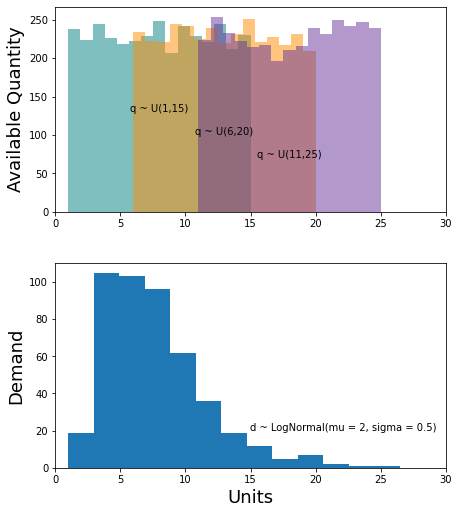

In [34]:

spec = {"height_ratios":[1, 1],"hspace":0.25,"bottom":0.1,"top":0.9}
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(7,8),gridspec_kw=spec)

lim_x = max(d.values())+5
lim_x = 30
cols = ["teal","darkorange","rebeccapurple"]
for i in range(len(q_dist)):
    ax1.hist([q_obs[i][k] for k in q_obs[i] if q_obs[i][k]>0],alpha=0.5,color=cols[i],bins=15)
    cin = st.t.interval(alpha=0.95, df=len(th[i])-1, loc=np.mean(th[i]), scale=st.sem(th[i])) 
    ax1.text(x=(q_dist[i][0]+q_dist[i][1])/2,y=100+(1-i)*30,s=f"q ~ U({q_dist[i][0]},{q_dist[i][1]})",ha="center")
ax1.set_ylabel("Available Quantity",fontsize=18)
ax1.set_xlim(0,lim_x)

#x = np.linspace(0, lim_x, 10000)
#mu = np.exp(2+0.5**2/2)
#sigma = np.sqrt(np.exp(2*2+0.5**2)*(np.exp(0.5**2)-1))
#pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))/ (x * sigma * np.sqrt(2 * np.pi)))
#pdf = st.lognorm(2,sigma=0.5)
#ax21 = ax2.twinx()
#ax21.plot(x, pdf, linewidth=2, color='r')
#ax21
ax2.hist(d.values(),bins=25)
ax2.text(x=lim_x/2,y=20,s=f"d ~ LogNormal(mu = 2, sigma = 0.5)")
ax2.set_xlim(0,lim_x)
ax2.set_xlabel("Units",fontsize=18)
ax2.set_ylabel("Demand",fontsize=18)
plt.savefig(f'./Instance dist.png', dpi=300, transparent=True)